In [4]:
!pip install opendatasets



In [5]:
import opendatasets as od

In [6]:
dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition'

In [8]:
od.download(dataset_url,force= True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: 
Your Kaggle username: 
Your Kaggle username: aniketpatra
Your Kaggle Key: ··········


100%|██████████| 225M/225M [00:01<00:00, 215MB/s]


###import the dataset into pytorch
### use the 'imagefolder' class from torchvision




In [9]:
import os

In [10]:
data_dir = "./flowers-recognition/flowers"

In [11]:
os.listdir(data_dir)

['rose', 'dandelion', 'tulip', 'daisy', 'sunflower']

In [12]:
os.listdir(data_dir)

['rose', 'dandelion', 'tulip', 'daisy', 'sunflower']

In [13]:
from torchvision.datasets import ImageFolder

In [14]:
dataset = ImageFolder(data_dir)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

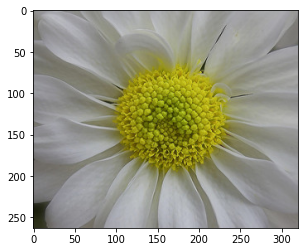

In [16]:
img, label = dataset[0]
plt.imshow(img)

In [17]:
import torchvision.transforms as tt

In [18]:
dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(64), 
                                            tt.RandomCrop(64),
                                            tt.ToTensor()]))

### img.permute is used to keep the kernel size as the last dimension

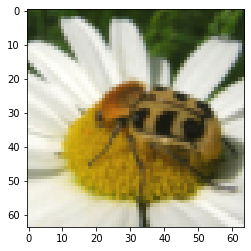

In [19]:
img, label = dataset[120]
plt.imshow(img.permute((1,2,0)))

In [20]:
val_pct = 0.1
val_size = int(val_pct*len(dataset))
train_size= len(dataset) - val_size

train_size, val_size

(3886, 431)

In [21]:
from torch.utils.data import random_split
train_ds, valid_ds = random_split(dataset, [train_size, val_size])

In [22]:
len(train_ds), len(valid_ds)

(3886, 431)

### Create a Training Batch

In [23]:
batch_size = 128

from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle = True,
                      num_workers = 4,
                      pin_memory = True)
valid_dl = DataLoader(valid_ds, batch_size,
                    num_workers = 4,
                    pin_memory = True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Observe the Training Batch

In [24]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
       fig, ax = plt.subplots(figsize=(12, 6))
       ax.set_xticks([]); ax.set_yticks([])
       ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
       break


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


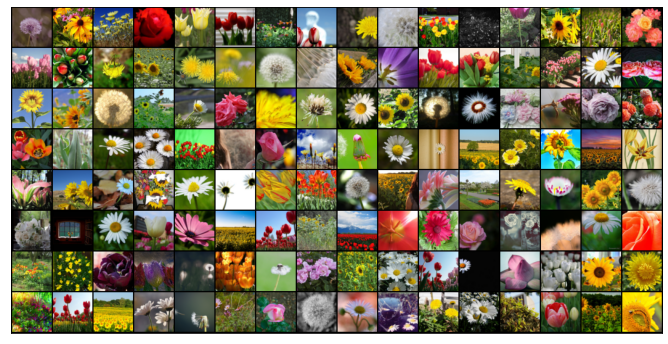

In [25]:
show_batch(train_dl)

In [26]:
for cls in os.listdir(data_dir):
  print(cls,':', len(os.listdir(data_dir + '/' + cls)) )

rose : 784
dandelion : 1052
tulip : 984
daisy : 764
sunflower : 733


### GPU/CPU Utility Functions and Classes

In [27]:
import torch
def get_default_device():
  "Pick GPU if avaialable, else CPU"
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
   " Move tensor(s) to chosen device"
   if isinstance(data, (list,tuple)):
     return (to_device(x, device) for x in data)
   return data.to(device, non_blocking = True)     

class DeviceDataLoader():
   'Wrap a dataloader to move data to a device'
   def __init__(self,dl, device):
     self.dl = dl
     self.device = device

   def __iter__(self):
     for b in self.dl:
       yield to_device(b, self.device)

   def __len__(self):
     return len(self.dl)



In [28]:
torch.cuda.is_available()

True

In [29]:
device = get_default_device()
device

device(type='cuda')

In [30]:
img, label = dataset[0]

In [31]:
img.shape

torch.Size([3, 64, 64])

In [32]:
img_cpu = to_device(img, device)
img_cpu.device

device(type='cuda', index=0)

In [33]:
 train_dl = DeviceDataLoader(train_dl, device)
 valid_dl = DeviceDataLoader(valid_dl, device)

### Model and Training Utilities

In [41]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
  'calculate loss for a batch of training data'
  def training_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    'loss and accuracy for a batch of validation data'
    images, labels = batch 
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

  def epoch_end(self, epoch, result):
    print('Epoch[{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}'.format(
        epoch, result['train_loss'], result['val_loss'], result['val_acc'] ))  
    
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))    



In [35]:
@torch.no_grad()
def evaluate(model, val_loader):

  "evaluates the model performance on the validation set"
  model.eval()
  outputs = [model.validation_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model,train_loader, val_loader, opt_func = torch.optim.SGD):

  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
      model.train()
      train_losses = []
      for batch in train_loader :
          loss = model.training_step(batch)
          train_losses.append(loss)
          loss.backward() 
          optimizer.step()
          optimizer.zero_grad()

      result = evaluate(model, val_loader)
      result['train_loss'] = torch.stack(train_losses).mean().item()
      model.epoch_end(epoch, result)
      history.append(result)
  return history    




### DEFINE MODEL

In [36]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        # Input: 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), # 128 x 128 x 32 x 32
                                  conv_block(128, 128)) # 128 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8 
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8 
                                  conv_block(512, 512)) # 128 x 512 x 8 x 8 
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), # 128 x 512 x 1 x 1 
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [37]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Pass one batch of input tensors

In [39]:
for batch in train_dl:
  images,label = batch
  print('images.shape', images.shape)
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape torch.Size([128, 3, 64, 64])
images.device cuda:0
preds.shape torch.Size([128, 5])


##Train the Model

In [42]:
history = [evaluate(model, valid_dl)]
history

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[{'val_acc': 0.15886801481246948, 'val_loss': 1.6155915260314941}]

In [51]:
history += fit(5, 0.0001, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[0], train_loss: 0.4956, val_loss: 0.6143, val_acc: 0.7856
Epoch[1], train_loss: 0.4576, val_loss: 0.6152, val_acc: 0.7928
Epoch[2], train_loss: 0.4319, val_loss: 0.6030, val_acc: 0.8017
Epoch[3], train_loss: 0.4099, val_loss: 0.6255, val_acc: 0.8007
Epoch[4], train_loss: 0.3952, val_loss: 0.5772, val_acc: 0.8182


In [52]:
history += fit(5, 0.0002, model, train_dl, valid_dl, torch.optim.Adam)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[0], train_loss: 0.4125, val_loss: 0.5619, val_acc: 0.8269
Epoch[1], train_loss: 0.3885, val_loss: 0.5660, val_acc: 0.8196
Epoch[2], train_loss: 0.3567, val_loss: 0.5762, val_acc: 0.8118
Epoch[3], train_loss: 0.3519, val_loss: 0.5993, val_acc: 0.8138
Epoch[4], train_loss: 0.3174, val_loss: 0.5844, val_acc: 0.8216


##PLOT LOSS AND ACCURACY

In [53]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

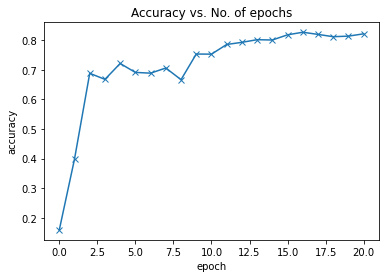

In [54]:
plot_accuracies(history)

In [55]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

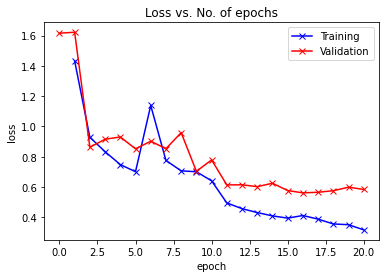

In [56]:
plot_losses(history)

##Test with individual Images

In [57]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [58]:
def show_image_prediction(img, label):
    plt.imshow(img.permute((1, 2, 0)))
    pred = predict_image(img, model, dataset.classes)
    print('Target:', dataset.classes[label])
    print('Prediction:', pred)

Target: sunflower
Prediction: sunflower


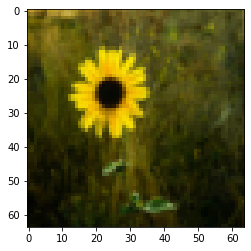

In [63]:
show_image_prediction(*valid_ds[90])

Target: sunflower
Prediction: sunflower


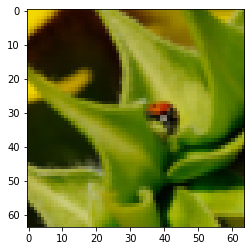

In [62]:
show_image_prediction(*valid_ds[3])